In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression

from statsmodels.stats.proportion import proportions_ztest

In [10]:
# Set display options
pd.set_option('display.max_columns', None)

In [11]:
# Load the processed data as pickle files to keep data types
data_processed = "../data/processed"
apps = pd.read_pickle(f"{data_processed}/applications.pkl")
company = pd.read_pickle(f"{data_processed}/company.pkl")
payments = pd.read_pickle(f"{data_processed}/payment.pkl")
df = pd.read_pickle(f"{data_processed}/merged.pkl")

In [12]:
df.head()

,company_id,invoice_id,invoice_date,due_date,payment_date,default_status,invoice_amount_clean,days_until_due,days_past_due,paid_on_time,incorporation_date,industry_segment,working_capital,net_worth,legal_form,postcode_area,type_of_external_credit_rating,external_credit_rating_label,application_id,risk_score,app_date_only,app_day_of_week,app_time,requested_amount_clean,approved_amount_ord
0,337,31,2022-02-01,2022-03-02,2022-03-19,False,3012,29,17.0,False,1995-10-15,Water,10256000.0,25443000.0,Private limited with Share Capital,NG4,External credit risk,Very Low Risk,31,3.260000,2022-02-01,Tuesday,14:11:00,3012,over 500000
1,1006,11,2022-02-01,2022-03-02,2022-04-04,False,5568,29,33.0,False,2015-12-18,Construct,827676.0,793393.0,Private limited with Share Capital,DY1,External credit risk,Moderate Risk,11,1.990000,2022-02-01,Tuesday,13:20:00,5568,100000-500000
2,490,33,2022-02-01,2022-03-02,2022-04-09,False,4368,29,38.0,False,2002-09-13,TransportStorage,4090612.0,4723347.0,Private limited with Share Capital,EC2V,External credit risk,Low Risk,33,4.080000,2022-02-01,Tuesday,14:12:00,4368,over 500000
3,63,1,2022-02-01,2022-03-02,2022-02-20,False,78,29,-10.0,True,2011-05-19,unknown,114254.0,194692.0,Sole Trader/Other,unknown,unknown,NaN,1,5.701493,2022-02-01,Tuesday,09:07:00,78,10000-50000
4,1175,25,2022-02-01,2022-03-02,2022-05-10,False,53,29,69.0,False,2018-02-13,WholesaleRetail,-125914.0,420638.0,Private limited with Share Capital,LE1,External credit risk,Low Risk,25,2.340000,2022-02-01,Tuesday,14:03:00,53,100000-500000


In [13]:
df['industry_segment'].unique()

['Water', 'Construct', 'TransportStorage', 'unknown', 'WholesaleRetail', ..., 'InfoComm', 'FinancialInsurance', 'Mining', 'AgrFish', 'PublicAdminDefence']
Length: 20
Categories (20, object): ['AccommFood', 'Admin', 'AgrFish', 'ArtsRecr', ..., 'TransportStorage', 'Water', 'WholesaleRetail', 'unknown']

In [14]:


# 1. Flag Construction segment
df['is_construction'] = df['industry_segment'] == 'Construct'

# 2. Select numeric features for comparison
num_features = [
    'working_capital',
    'net_worth',
    'invoice_amount_clean',
    'days_past_due',
    'risk_score'
]

# 3. Compute summary statistics by segment
print("### Summary Statistics per Inductry")
display(df.groupby('industry_segment')[num_features] \
                  .agg(['mean', 'median', 'std', 'count']))

# 3. Compute summary statistics by segment
print("### Summary Statistics (Construction vs Others)")
display(df.groupby('is_construction')[num_features] \
                  .agg(['mean', 'median', 'std', 'count']))

### Summary Statistics per Inductry


C:\Users\chloe\AppData\Local\Temp\ipykernel_19060\1242556806.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('industry_segment')[num_features] \


working_capital                                 \
                              mean     median           std count   
industry_segment                                                    
AccommFood           -3.966655e+06    15177.0  1.937531e+07   421   
Admin                 6.893457e+06   114254.0  3.332057e+07   236   
AgrFish               3.625426e+06  5994231.0  2.863559e+06    14   
ArtsRecr              1.480653e+06   116330.0  1.371995e+07    47   
Construct             2.775168e+06   143284.0  2.517311e+07   757   
Educ                  1.666138e+06   314339.0  3.444662e+06    85   
Electr                1.647655e+06    67923.0  4.364681e+06     8   
FinancialInsurance    1.275032e+07   262181.0  4.963013e+07    19   
HealthSocialWork     -5.786868e+04   284516.0  5.098119e+06    59   
InfoComm              3.134591e+06   259458.0  7.445605e+06    46   
Manuf                 1.228584e+06     9257.0  9.483290e+06   656   
Mining               -6.947400e+04   -69474.0  0.000000e+00     2   
Other                 2.840931e+07   561791.0  4.804223e+07   113   
ProfServ              9.926856e+05    84012.5  3.673296e+06   152   
PublicAdminDefence    1.693900e+04    16939.0  0.000000e+00     3   
RealEstate            2.976027e+04  -275551.0  7.336641e+05    59   
TransportStorage      2.018736e+06   300577.0  6.574459e+06    55   
Water                 2.286326e+06    31523.0  4.258521e+06    39   
WholesaleRetail       2.719477e+06   110200.0  2.844619e+07  1025   
unknown               1.039870e+05   114254.0  1.128422e+05   204   

                       net_worth                                  \
                            mean      median           std count   
industry_segment                                                   
AccommFood          1.950616e+07     25159.0  9.780750e+07   421   
Admin               9.953432e+06    210741.5  4.542078e+07   236   
AgrFish             1.641478e+07  27836792.0  1.373391e+07    14   
ArtsRecr            7.324512e+06    285140.0  3.887640e+07    47   
Construct           3.200319e+06    169332.0  2.569822e+07   757   
Educ                9.147210e+06   5416025.0  1.370192e+07    85   
Electr              2.018475e+07     20758.0  5.679900e+07     8   
FinancialInsurance  1.455435e+07   1965000.0  5.112933e+07    19   
HealthSocialWork    3.288679e+06    644919.0  7.722793e+06    59   
InfoComm            2.978818e+06    342006.0  6.302613e+06    46   
Manuf               3.445554e+06    834731.0  1.131480e+07   656   
Mining             -4.201600e+04    -42016.0  0.000000e+00     2   
Other               5.731556e+07    617108.0  9.678639e+07   113   
ProfServ            1.957294e+06     41541.0  8.069981e+06   152   
PublicAdminDefence  1.711300e+04     17113.0  0.000000e+00     3   
RealEstate          1.895505e+06   2888569.0  1.341396e+06    59   
TransportStorage    5.159415e+06   2145272.0  1.749438e+07    55   
Water               6.100967e+06    962464.0  1.005116e+07    39   
WholesaleRetail     3.283308e+06    194692.0  2.741299e+07  1025   
unknown             2.355836e+05    194692.0  3.453258e+05   204   

                   invoice_amount_clean                             \
                                   mean  median          std count   
industry_segment                                                     
AccommFood                   326.895487   179.0   514.737981   421   
Admin                       1297.851695   500.5  2363.789354   236   
AgrFish                     4936.714286  3963.0  3750.539026    14   
ArtsRecr                     460.617021   216.0   642.193542    47   
Construct                   1452.247028   672.0  3210.020271   757   
Educ                         583.517647   152.0  1017.670854    85   
Electr                       493.000000   444.0   484.323387     8   
FinancialInsurance          1001.842105   450.0  1678.358201    19   
HealthSocialWork             329.050847   139.0   495.603409    59   
InfoComm                  

### Summary Statistics (Construction vs Others)


working_capital                                   net_worth  \
                           mean    median           std count          mean   
is_construction                                                               
False              2.402933e+06   93049.0  2.311009e+07  3243  7.944234e+06   
True               2.775168e+06  143284.0  2.517311e+07   757  3.200319e+06   

                                              invoice_amount_clean         \
                   median           std count                 mean median   
is_construction                                                             
False            234896.0  4.644210e+07  3243          1259.967623  435.0   
True             169332.0  2.569822e+07   757          1452.247028  672.0   

                                   days_past_due                          \
                         std count          mean median        std count   
is_construction                                                            
False            2745.343460  3243      7.177647    2.0  32.993291  3051   
True             3210.020271   757      6.627019    3.0  25.494788   681   

                risk_score                         
                      mean median       std count  
is_construction                                    
False             4.788063   3.26  4.903281  3243  
True              5.025244   3.26  5.188669   757

## Testing Difference in Default Rates: Construction vs. Other Industries
> Is the default rate in the Construction segment different from the default rate in all other segments?

### Hypotheses

- **Null hypothesis (H₀):**  
  $$
  p_{C} \le p_{O}
  $$  
  The default proportion in Construction is less than or equal to that in Other industries.

- **Alternative hypothesis (H₁):**  
  $$
  p_{C} > p_{O}
  $$  
  The default proportion in Construction is greater than that in Other industries.

### When to Use a Two-Proportion Z-Test

- You have **two independent groups**:  
  1. Construction firms  
  2. All other firms
- You observe a **binary outcome** in each group: default (`True`) or no default (`False`).
- You wish to test whether the underlying population proportions $p_C$ and $p_O$ are equal.


### Test Statistic

1. **Sample proportions**  
   $$
   \hat p_C = \frac{k_C}{n_C}, 
   \quad
   \hat p_O = \frac{k_O}{n_O}
   $$  
   where  
   - $k_C$, $k_O$ are the number of defaults in Construction and Other groups  
   - $n_C$, $n_O$ are the total observations in each group  

2. **Pooled proportion**  
   $$
   \hat p = \frac{k_C + k_O}{n_C + n_O}
   $$

3. **Z-statistic**  
   $$
   Z
   = \frac{\hat p_C - \hat p_O}
          {\sqrt{\hat p \,(1 - \hat p)\,\bigl(\tfrac{1}{n_C} + \tfrac{1}{n_O}\bigr)}}
   $$

### Assumptions

1. **Independence** of observations within and between groups.  
2. **Sample sizes** large enough for normal approximation:  
   $n_C \hat p \ge 5,\; n_C(1-\hat p)\ge 5$, and similarly for $n_O$.

### Interpretation

- If **p-value < 0.05**, conclude that Construction firms have a **significantly higher** default rate than other industries at the 5% level.  
- If **p-value ≥ 0.05**, there is insufficient evidence to claim Construction’s default rate is higher.    

In [16]:
# 1. Total bills in each group
n_constr = df[df['is_construction']].shape[0]   # e.g., 757
n_other  = df[~df['is_construction']].shape[0]  # e.g., 3243

# 2. Number of defaults in each group
k_constr = df[(df['is_construction']) & (df['default_status'])].shape[0]
k_other  = df[(~df['is_construction']) & (df['default_status'])].shape[0]

print(f"Construction: {k_constr}/{n_constr} defaults  → rate = {k_constr/n_constr:.3%}")
print(f"Other segs : {k_other}/{n_other} defaults  → rate = {k_other/n_other:.3%}\n")

# 3. One‐sided two‐proportion Z-test (testing p_constr > p_other)
counts = [k_constr, k_other]
nobs   = [n_constr, n_other]

stat, pval_one_sided = proportions_ztest(
    count=counts,
    nobs=nobs,
    alternative='larger'   # one-sided: tests p1 > p2
)

print(f"Z-statistic       = {stat:.5f}")
print(f"One‐sided p-value = {pval_one_sided:.5f}")

# 4. Interpret at α = 0.05
alpha = 0.05
if pval_one_sided < alpha:
    print(f"→ Reject H₀: Construction’s default rate is significantly higher (p < {alpha}).")
else:
    print(f"→ Fail to reject H₀: No evidence that Construction’s default rate is higher (p ≥ {alpha}).")

Construction: 52/757 defaults  → rate = 6.869%
Other segs : 122/3243 defaults  → rate = 3.762%

Z-statistic       = 3.77384
One‐sided p-value = 0.00008
→ Reject H₀: Construction’s default rate is significantly higher (p < 0.05).


In [17]:
df.head()

,company_id,invoice_id,invoice_date,due_date,payment_date,default_status,invoice_amount_clean,days_until_due,days_past_due,paid_on_time,incorporation_date,industry_segment,working_capital,net_worth,legal_form,postcode_area,type_of_external_credit_rating,external_credit_rating_label,application_id,risk_score,app_date_only,app_day_of_week,app_time,requested_amount_clean,approved_amount_ord,is_construction
0,337,31,2022-02-01,2022-03-02,2022-03-19,False,3012,29,17.0,False,1995-10-15,Water,10256000.0,25443000.0,Private limited with Share Capital,NG4,External credit risk,Very Low Risk,31,3.260000,2022-02-01,Tuesday,14:11:00,3012,over 500000,False
1,1006,11,2022-02-01,2022-03-02,2022-04-04,False,5568,29,33.0,False,2015-12-18,Construct,827676.0,793393.0,Private limited with Share Capital,DY1,External credit risk,Moderate Risk,11,1.990000,2022-02-01,Tuesday,13:20:00,5568,100000-500000,True
2,490,33,2022-02-01,2022-03-02,2022-04-09,False,4368,29,38.0,False,2002-09-13,TransportStorage,4090612.0,4723347.0,Private limited with Share Capital,EC2V,External credit risk,Low Risk,33,4.080000,2022-02-01,Tuesday,14:12:00,4368,over 500000,False
3,63,1,2022-02-01,2022-03-02,2022-02-20,False,78,29,-10.0,True,2011-05-19,unknown,114254.0,194692.0,Sole Trader/Other,unknown,unknown,NaN,1,5.701493,2022-02-01,Tuesday,09:07:00,78,10000-50000,False
4,1175,25,2022-02-01,2022-03-02,2022-05-10,False,53,29,69.0,False,2018-02-13,WholesaleRetail,-125914.0,420638.0,Private limited with Share Capital,LE1,External credit risk,Low Risk,25,2.340000,2022-02-01,Tuesday,14:03:00,53,100000-500000,False


Differences in business characteristics:

Q: what type of legal form do the construction companies take on? Does this differ from the other sectors?
Q: same for incorporation_date, working_capital, net_worth, postcode_area, type_of_external_credit_rating and external_credit_rating_labe
Q: Many many of the construction segment rows have an external credit rating?

Q: how significant are the defaulted amounts compared to other segments? Are they big/small etc?
Q: does the risk score assigned to the construction companies reflect their default risk


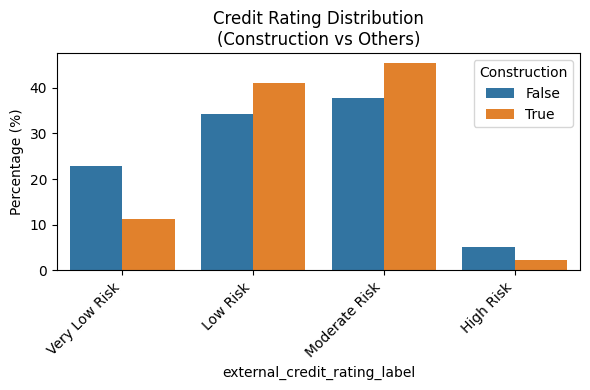

In [8]:

# Compare external credit–rating distributions
rating_dist = (
    df
    .groupby('is_construction')['external_credit_rating_label']
    .value_counts(normalize=True)
    .mul(100)
    .rename('pct')
    .reset_index()
)
plt.figure(figsize=(6,4))
sns.barplot(
    data=rating_dist,
    x='external_credit_rating_label',
    y='pct',
    hue='is_construction'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.title('Credit Rating Distribution\n(Construction vs Others)')
plt.legend(title='Construction')
plt.tight_layout()
plt.show()


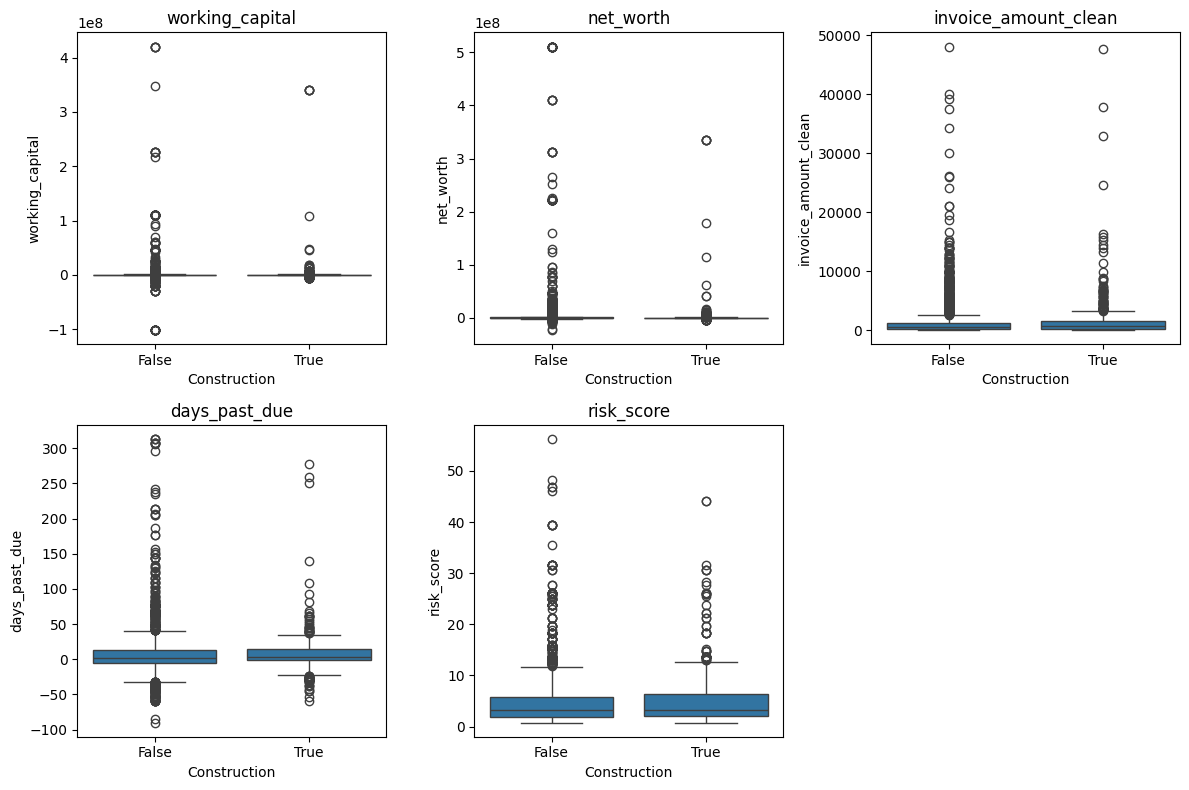

In [9]:
# 5. Box-plots for key numeric features
plt.figure(figsize=(12, 8))
for i, feat in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='is_construction', y=feat, data=df)
    plt.title(feat)
    plt.xlabel('Construction')
plt.tight_layout()
plt.show()